In [1]:
import io
from collections import defaultdict
import random

import chess
import chess.pgn
import chess.engine

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
from analysis_utils import get_first_move_with_bad_move, get_all_losses_for_my_moves, get_move
from local_data_manager import get_all_games

In [3]:
games = get_all_games('chessprimes', None, download=False, parse=False, analysis_time=0.25)

In [9]:
def get_total_number_moves(game):
    i = 0
    while len(game.variations):
        i += 1
        game = game.variations[0]
    return i

In [10]:
num_moves = list(map(get_total_number_moves, games))

In [11]:
print(f"on average total half moves is {sum(num_moves)/len(num_moves)}")

on average total half moves is 71.10741510741511


In [12]:
games[31].headers

Headers(Event='Rated Blitz game', Site='https://lichess.org/2K0M7VUD', Date='2021.01.02', Round='?', White='Ziata', Black='chessprimes', Result='1-0', BlackElo='1882', BlackRatingDiff='-5', ClockIncr='3', ClockInitial='300', ClockTotal='420', ECO='A06', ID='2K0M7VUD', Opening='Zukertort Opening: Tennison Gambit', Perf='blitz', Speed='blitz', Status='mate', Termination='Normal', TimeControl='300+3', UTCDate='2021.01.02', UTCTime='21:51:24', Variant='Standard', WhiteElo='1934', WhiteRatingDiff='+5', opening="{'eco': 'A06', 'name': 'Zukertort Opening: Tennison Gambit', 'ply': 3}")

-301


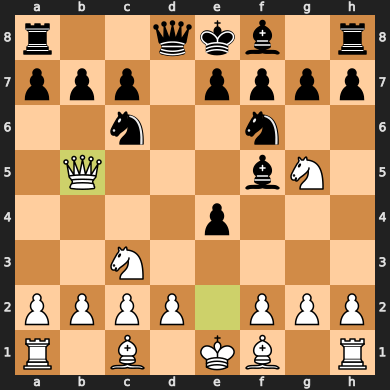

In [13]:
game = games[31]
move_num = 11
move = get_move(game, move_num)
print(move.eval())
move.board()

In [14]:
moves = []
diffs = []
checkmate_moves = []
no_data_moves = []
for i, game in enumerate(games):
    move_num, diff = get_first_move_with_bad_move(game, 'chessprimes', min_rating=-175, max_rating=175)
    if diff is None:
        no_data_moves.append(i)
        continue
    if diff == float('inf'):
        checkmate_moves.append(i)
        continue
    moves.append(move_num // 2 if move_num % 2 == 0 else move_num // 2 + 1)
    diffs.append(diff)

In [15]:
print(f"On average I lose {sum(diffs)/len(diffs)} to go into a bad position on my {sum(moves)/len(moves)}'th move'")

On average I lose 241.9083728278041 to go into a bad position on my 13.902053712480253'th move'


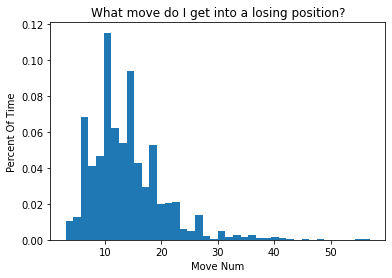

In [16]:
plt.hist(moves, density=True, bins=40)  # density=False would make counts
plt.ylabel('Percent Of Time')
plt.xlabel('Move Num')
plt.title("What move do I get into a losing position?")
plt.savefig('percent_move_losing.png')

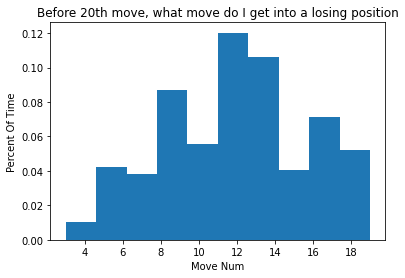

In [17]:
plt.hist(list(filter(lambda m: m < 20, moves)), density=True, bins=10)  # density=False would make counts
plt.ylabel('Percent Of Time')
plt.xlabel('Move Num')
plt.title("Before 20th move, what move do I get into a losing position");

In [18]:
d_set = defaultdict(list)
for move_num, diff in zip(moves, diffs):
    d_set[move_num].append(diff)
datas = []
for move_num, idv_diffs in d_set.items():
    datas.append(
        {
            'move_num': move_num,
            'avg_loss': sum(idv_diffs)/len(idv_diffs),
            'total_moves': len(idv_diffs)
        }
    )

In [19]:
data = pd.DataFrame(datas).sort_values(by='move_num')

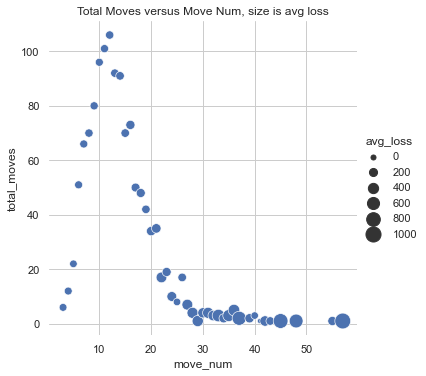

In [20]:
sns.set_theme(style="whitegrid")

cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
g = sns.relplot(
    data=data,
    x="move_num", y="total_moves",
    size="avg_loss",
    palette=cmap, sizes=(25, 250),
)
# g.set(xscale="log", yscale="log")
g.ax.xaxis.grid(True, "minor", linewidth=.25)
g.ax.yaxis.grid(True, "minor", linewidth=.25)
g.despine(left=True, bottom=True)
plt.title('Total Moves versus Move Num, size is avg loss')
plt.savefig('images/replotavg_total_moves_versus_move_num.png');

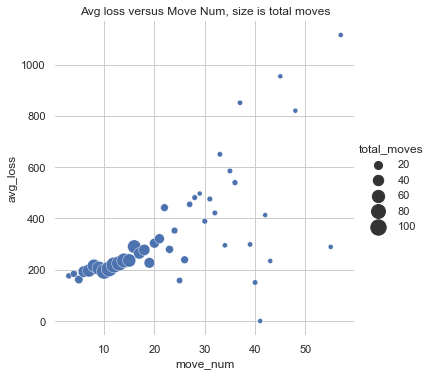

In [21]:
sns.set_theme(style="whitegrid")

cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
g = sns.relplot(
    data=data,
    x="move_num", y="avg_loss",
    size="total_moves",
    palette=cmap, sizes=(25, 250),
)
# g.set(xscale="log", yscale="log")
g.ax.xaxis.grid(True, "minor", linewidth=.25)
g.ax.yaxis.grid(True, "minor", linewidth=.25)
g.despine(left=True, bottom=True)
plt.title('Avg loss versus Move Num, size is total moves')
plt.savefig('images/replotavg_loss_versus_move_num.png');

In [22]:
game.headers

Headers(Event='Rated Blitz game', Site='https://lichess.org/i2KnIEpr', Date='2018.12.04', Round='?', White='chessprimes', Black='syolcu', Result='0-1', BlackElo='1521', BlackRatingDiff='+7', ClockIncr='0', ClockInitial='180', ClockTotal='180', ECO='D00', ID='i2KnIEpr', Opening='Blackmar-Diemer Gambit: Ryder Gambit', Perf='blitz', Speed='blitz', Status='resign', Termination='Normal', TimeControl='180+0', UTCDate='2018.12.04', UTCTime='18:07:47', Variant='Standard', WhiteElo='1500', WhiteRatingDiff='-165', opening="{'eco': 'D00', 'name': 'Blackmar-Diemer Gambit: Ryder Gambit', 'ply': 9}")

In [23]:
for i, game in enumerate(games):
    for move_num, loss in get_all_losses_for_my_moves(game, 'chessprimes'):
        move_num = move_num // 2 if move_num % 2 == 0 else move_num // 2 + 1
        if loss < -8000:
            print(i, move_num, loss)
            break

263 62 -8723
281 42 -8149
1386 39 -8333


In [24]:
games[263].headers

Headers(Event='Rated Blitz game', Site='https://lichess.org/Zxa2vFdg', Date='2020.11.29', Round='?', White='Lolcuneo', Black='chessprimes', Result='1-0', BlackElo='1876', BlackRatingDiff='-5', ClockIncr='2', ClockInitial='180', ClockTotal='260', ECO='B20', ID='Zxa2vFdg', Opening='Sicilian Defense: Snyder Variation', Perf='blitz', Speed='blitz', Status='resign', Termination='Normal', TimeControl='180+2', UTCDate='2020.11.29', UTCTime='15:20:32', Variant='Standard', WhiteElo='1906', WhiteRatingDiff='+5', opening="{'eco': 'B20', 'name': 'Sicilian Defense: Snyder Variation', 'ply': 3}")

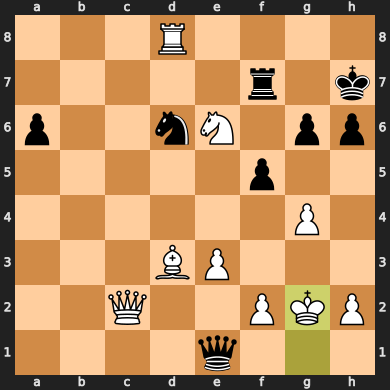

In [25]:
get_move(games[3], 63).board()

In [26]:
data_buckets = defaultdict(list)
data_buckets_inf = defaultdict(int)
for game in games:
    for move_num, loss in get_all_losses_for_my_moves(game, 'chessprimes'):
        move_num = move_num // 2 if move_num % 2 == 0 else move_num // 2 + 1
        if loss == float('inf') or loss < -2500:
            data_buckets_inf[move_num] += 1
        else:
            data_buckets[move_num].append(loss if loss >= 20 else 0)  # appending zero for near-perfect moves, especially because analysis was only 0.25 seconds
        
datas = []
for move_num, losses in data_buckets.items():
    datas.append({
        'move_num': move_num,
        'avg_loss': sum(losses)/len(losses),
        'total_moves': len(losses)
    })
datas = pd.DataFrame(datas)
datas_inf = []
for move_num, num_losses in data_buckets_inf.items():
    datas_inf.append({
        'move_num': move_num,
        'avg_loss': float('inf'),
        'total_moves': num_losses
    })
datas_inf = pd.DataFrame(datas_inf)

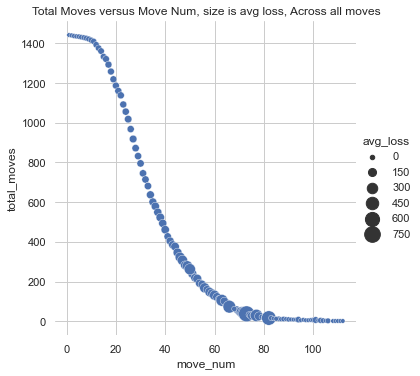

In [27]:
sns.set_theme(style="whitegrid")

cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
g = sns.relplot(
    data=datas,
    x="move_num", y="total_moves",
    size="avg_loss",
    palette=cmap, sizes=(20, 250),
)
# g.set(xscale="log", yscale="log")
g.ax.xaxis.grid(True, "minor", linewidth=.25)
g.ax.yaxis.grid(True, "minor", linewidth=.25)
g.despine(left=True, bottom=True)
plt.title('Total Moves versus Move Num, size is avg loss, Across all moves')
plt.savefig('images/replotavg_total_moves_versus_move_num_all_moves_loss.png');

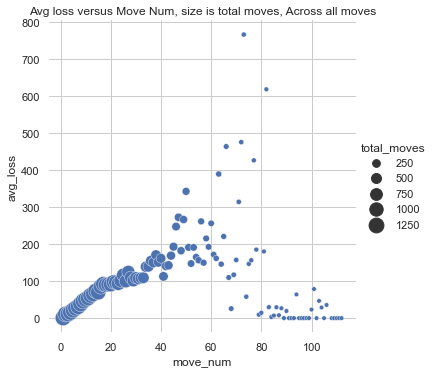

In [28]:
sns.set_theme(style="whitegrid")

cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
g = sns.relplot(
    data=datas,
    x="move_num", y="avg_loss",
    size="total_moves",
    palette=cmap, sizes=(20, 250),
)
# g.set(xscale="log", yscale="log")
g.ax.xaxis.grid(True, "minor", linewidth=.25)
g.ax.yaxis.grid(True, "minor", linewidth=.25)
g.despine(left=True, bottom=True)
plt.title('Avg loss versus Move Num, size is total moves, Across all moves')
plt.savefig('images/replotavg_avg_loss_versus_move_num_all_moves.png');

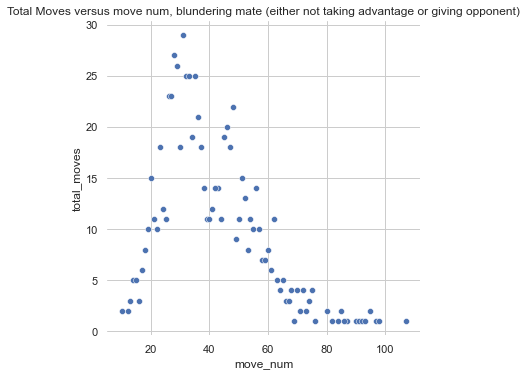

In [29]:
sns.set_theme(style="whitegrid")

cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
g = sns.relplot(
    data=datas_inf,
    x="move_num", y="total_moves",
#     size="total_moves",
    palette=cmap, sizes=(20, 250),
)
# g.set(xscale="log", yscale="log")
g.ax.xaxis.grid(True, "minor", linewidth=.25)
g.ax.yaxis.grid(True, "minor", linewidth=.25)
g.despine(left=True, bottom=True)
plt.title('Total Moves versus move num, blundering mate (either not taking advantage or giving opponent)')
plt.savefig('images/blundering_mate.png'); 

In [30]:
games[0].headers._others

{'BlackElo': '1928',
 'BlackRatingDiff': '+0',
 'ClockIncr': '2',
 'ClockInitial': '180',
 'ClockTotal': '260',
 'ECO': 'D02',
 'ID': 'bB1gKq4J',
 'Opening': "Queen's Pawn Game: London System",
 'Perf': 'blitz',
 'Speed': 'blitz',
 'Status': 'draw',
 'Termination': 'Normal',
 'TimeControl': '180+2',
 'UTCDate': '2021.01.04',
 'UTCTime': '01:38:27',
 'Variant': 'Standard',
 'WhiteElo': '1901',
 'WhiteRatingDiff': '+0',
 'opening': '{\'eco\': \'D02\', \'name\': "Queen\'s Pawn Game: London System", \'ply\': 5}'}

In [32]:
df['loss'].describe()

count    50619.0
mean         inf
std          NaN
min       -965.0
25%          0.0
50%         20.0
75%         77.0
max          inf
Name: loss, dtype: float64

In [34]:
def group_it_by(df, colname, aggs, f):
    tmp = df.copy()
    tmp[colname] = df.apply(f, axis=1)
    tmp2 = tmp[['move_num', 'loss', colname]].groupby(colname, as_index=False).apply(lambda x: x.reset_index(drop=True)).reset_index()[['move_num', 'loss', colname]]
    tmp3 = tmp2.groupby('move_num').agg({
        'loss': ['count', 'mean'],
        colname: aggs
    }).reset_index()
    tmp3.columns = ['_'.join(filter(None, col)) for col in tmp3.columns]
    return tmp3

In [35]:
colname = 'playing_against_higher_rated'
f = lambda x: int(int(x['BlackElo']) > int(x['WhiteElo'])) if x['playing_white'] else int(int(x['WhiteElo']) > int(x['BlackElo']))
tmp = df[df['loss'] != float('inf')].copy()
tmp[colname] = df.apply(f, axis=1)

In [36]:
def get_data1(df, colname, f, apply_loss_n=0, remove_loss_zero=False):
    tmp = df[df['loss'] != float('inf')].copy()
    tmp['loss'] = tmp.apply(lambda x: x['loss'] if abs(x['loss']) > apply_loss_n else 0, axis=1)
    if remove_loss_zero:
        tmp = tmp[tmp['loss'] != 0]
    tmp[colname] = df.apply(f, axis=1)
    tmp2 = tmp[['move_num', 'loss', colname]].groupby([colname, 'move_num'], as_index=False).agg({
        'loss': ['count', 'mean'],
    })
    tmp2.columns = ['_'.join(filter(None, col)) for col in tmp2.columns]
    return tmp2

In [39]:
def get_data2(df, colname, f, apply_loss_n=0, remove_loss_zero=False):
    tmp = df[df['loss'] != float('inf')].copy()
    tmp['loss'] = tmp.apply(lambda x: x['loss'] if abs(x['loss']) > apply_loss_n else 0, axis=1)
    if remove_loss_zero:
        tmp = tmp[tmp['loss'] != 0]
    tmp[colname] = df.apply(f, axis=1)
    tmp2 = tmp[['move_num', 'loss', colname]].groupby([colname, 'move_num'], as_index=False).agg({
        'loss': ['count', 'mean'],
    })
    tmp2.columns = ['_'.join(filter(None, col)) for col in tmp2.columns]
    return tmp2

In [40]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [41]:
tmp = df[df['loss'] != float('inf')]
tmp = tmp[tmp['loss'] < -100]
tmp['loss'].describe()

count    370.00000
mean    -252.59459
std      196.94222
min     -965.00000
25%     -298.75000
50%     -160.00000
75%     -122.00000
max     -101.00000
Name: loss, dtype: float64

/Users/kennethgoodman/venv/lib/python3.6/site-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:


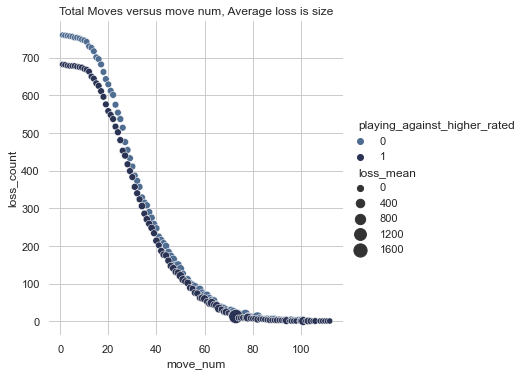

In [45]:
col = 'playing_against_higher_rated'
f = lambda x: int(int(x['BlackElo']) > int(x['WhiteElo'])) if x['playing_white'] else int(int(x['WhiteElo']) > int(x['BlackElo']))
data = get_data1(df, col, f, apply_loss_n=20)

sns.set_theme(style="whitegrid")


cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
hue = 'playing_against_higher_rated'
total_num_hue = len(set(data[hue].values))
g = sns.relplot(
    data=data,
    x="move_num", y="loss_count",
    size="loss_mean", hue="playing_against_higher_rated",
    palette=cmap.colors[random.sample(range(256), total_num_hue)], sizes=(10, 200),
)
# g.set(xscale="log", yscale="log")
g.ax.xaxis.grid(True, "minor", linewidth=.25)
g.ax.yaxis.grid(True, "minor", linewidth=.25)
g.despine(left=True, bottom=True)
plt.title('Total Moves versus move num, Average loss is size')
plt.savefig('images/total_move_versus_move_num_with_hue_for_higher_lower_rated.png'); 

/Users/kennethgoodman/venv/lib/python3.6/site-packages/seaborn/_core.py:163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:


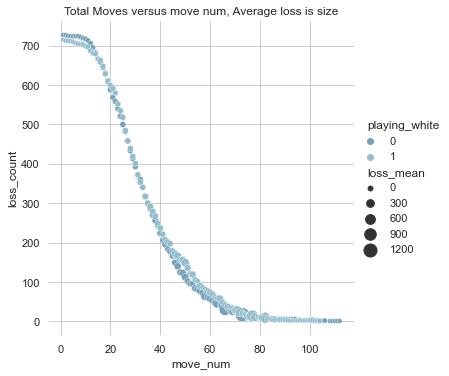

In [49]:
col = 'playing_white'
f = lambda x: int(x['playing_white'])
data = get_data1(df, col, f, apply_loss_n=20)

sns.set_theme(style="whitegrid")


cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
hue = 'playing_white'
total_num_hue = len(set(data[hue].values))
g = sns.relplot(
    data=data,
    x="move_num", y="loss_count",
    size="loss_mean", hue="playing_white",
    palette=cmap.colors[random.sample(range(256), total_num_hue)], sizes=(10, 200),
)
# g.set(xscale="log", yscale="log")
g.ax.xaxis.grid(True, "minor", linewidth=.25)
g.ax.yaxis.grid(True, "minor", linewidth=.25)
g.despine(left=True, bottom=True)
plt.title('Total Moves versus move num, Average loss is size')
plt.savefig('images/total_move_versus_move_num_with_hue_playing_white.png'); 

Text(0.5, 1.0, 'Total Moves versus move num, Average loss is size')

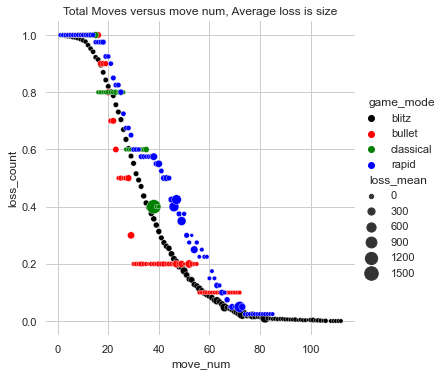

In [50]:
col = 'game_mode'
f = lambda x: x['Speed']
data = get_data1(df, col, f, apply_loss_n=20)

sns.set_theme(style="whitegrid")
g = data.groupby(['game_mode']).agg({'loss_count': 'max'}).reset_index()
d = dict(zip(g['game_mode'],g['loss_count'])) 
data['loss_count'] = data.apply(lambda x: x['loss_count'] / d[x['game_mode']], axis=1)

cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)
hue = 'game_mode'
total_num_hue = len(set(data[hue].values))
g = sns.relplot(
    data=data,
    x="move_num", y="loss_count",
    size="loss_mean", hue="game_mode",
    palette=['black', 'red', 'green', 'blue'], sizes=(10, 200),
)
# g.set(xscale="log", yscale="log")
g.ax.xaxis.grid(True, "minor", linewidth=.25)
g.ax.yaxis.grid(True, "minor", linewidth=.25)
g.despine(left=True, bottom=True)
plt.title('Total Moves versus move num, Average loss is size')
# plt.savefig('images/total_move_versus_move_num_with_hue_playing_white.png'); 

In [ ]:
# hue = win/loss

In [ ]:
# hue = innaccuracy/mistake/blunder

In [ ]:
# hue = clock